In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter

def calculate_avg_perplexity(seq, window_size=10):
    if len(seq) < window_size:
        return None
    dinucs = [seq[i:i+2] for i in range(len(seq)-1)]
    perplexities = []
    for i in range(len(seq) - window_size + 1):
        window = dinucs[i:i+window_size-1]
        counts = Counter(window)
        probs = np.array(list(counts.values())) / (window_size - 1)
        entropy = -np.sum(probs * np.log2(probs))
        perplexities.append(2 ** entropy)
    return np.mean(perplexities)

# Directory containing species folders
base_dir = "feature_fastas_all"

for species in sorted(os.listdir(base_dir)):
    species_path = os.path.join(base_dir, species)
    if not os.path.isdir(species_path):
        continue

    print(f"🔍 Processing: {species}")
    species_results = {}

    for file in sorted(os.listdir(species_path)):
        if file.endswith(".txt"):
            filepath = os.path.join(species_path, file)
            values = []
            with open(filepath, "r") as f:
                for line in f:
                    line = line.strip().upper()
                    if not line or line.startswith(">"):
                        continue
                    clean_seq = ''.join([c for c in line if c in "ATGC"])
                    perp = calculate_avg_perplexity(clean_seq)
                    if perp is not None:
                        values.append(perp)
            if values:
                col_name = os.path.splitext(file)[0]
                species_results[col_name] = values

    # Save to Excel
    if species_results:
        df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in species_results.items()]))
        out_path = f"{species}_perplexity.xlsx"
        df.to_excel(out_path, index=False)
        print(f"✅ Saved: {out_path}")


🔍 Processing: .ipynb_checkpoints
🔍 Processing: Apis_mellifera


KeyboardInterrupt: 

In [5]:
# Save this in a separate file (e.g., build_lookup.py) and run once
import numpy as np
from collections import Counter
from itertools import product
import pickle

def calculate_perplexity(window):
    dinucs = [window[i:i+2] for i in range(len(window)-1)]
    counts = Counter(dinucs)
    probs = np.array(list(counts.values())) / (len(dinucs))
    entropy = -np.sum(probs * np.log2(probs))
    return round(2 ** entropy, 6)

def build_perplexity_table(k=10):
    table = {}
    for kmer in map(''.join, product('ATGC', repeat=k)):
        table[kmer] = calculate_perplexity(kmer)
    return table

# Build and save
table = build_perplexity_table(k=10)
with open("perplexity_lookup.pkl", "wb") as f:
    pickle.dump(table, f)

print("✅ Perplexity lookup table saved to 'perplexity_lookup.pkl'")

✅ Perplexity lookup table saved to 'perplexity_lookup.pkl'


In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

# Load precomputed lookup table
with open("perplexity_lookup.pkl", "rb") as f:
    PERPLEXITY_TABLE = pickle.load(f)

def extract_sequences(filepath):
    """Reads a FASTA-like file and extracts clean sequences."""
    with open(filepath, 'r') as f:
        content = f.read().upper()
    content = re.sub(r'>[^\n]*', '', content)
    sequences = re.findall(r'[ATGC]+', content)
    return [s for s in sequences if len(s) >= 10]

def compute_avg_perplexity_lookup(seq, lookup_table, k=10):
    """Returns average perplexity of all k-mers in a sequence using precomputed table."""
    values = [lookup_table.get(seq[i:i+k]) for i in range(len(seq) - k + 1)]
    values = [v for v in values if v is not None]
    return np.mean(values) if values else None

def process_file(filepath):
    """Processes a single .txt file and returns a list of perplexity values."""
    sequences = extract_sequences(filepath)
    values = [compute_avg_perplexity_lookup(seq, PERPLEXITY_TABLE) for seq in sequences]
    values = [v for v in values if v is not None]
    col_name = os.path.splitext(os.path.basename(filepath))[0]
    return col_name, values if values else []

def process_species_folder(species_path):
    """Processes all .txt files in a species folder sequentially."""
    species_results = {}
    files = [os.path.join(species_path, file) for file in os.listdir(species_path) if file.endswith(".txt")]
    for filepath in tqdm(files, desc=f"Processing {os.path.basename(species_path)}"):
        try:
            col_name, values = process_file(filepath)
            if values:
                species_results[col_name] = values
        except Exception as e:
            print(f"❌ Error processing {filepath}: {e}")
    return species_results

def main(base_dir="feature_fastas_all"):
    """Main controller to process all species folders."""
    for species in sorted(os.listdir(base_dir)):
        species_path = os.path.join(base_dir, species)
        if not os.path.isdir(species_path):
            continue

        print(f"🔍 Processing: {species}")
        species_results = process_species_folder(species_path)

        if species_results:
            df = pd.DataFrame({k: pd.Series(v) for k, v in species_results.items()})
            out_path = f"{species}_perplexity.xlsx"
            df.to_excel(out_path, index=False)
            print(f"✅ Saved: {out_path}")

if __name__ == "__main__":
    main()


🔍 Processing: .ipynb_checkpoints


Processing .ipynb_checkpoints: 0it [00:00, ?it/s]


🔍 Processing: Apis_mellifera


Processing Apis_mellifera: 100%|█████████████████████████████████████████████████████████| 4/4 [03:34<00:00, 53.72s/it]


✅ Saved: Apis_mellifera_perplexity.xlsx
🔍 Processing: Arabidopsis_thaliana


Processing Arabidopsis_thaliana: 100%|█████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.45s/it]


✅ Saved: Arabidopsis_thaliana_perplexity.xlsx
🔍 Processing: Caenorhabditis_elegans


Processing Caenorhabditis_elegans: 100%|███████████████████████████████████████████████| 11/11 [01:46<00:00,  9.67s/it]


✅ Saved: Caenorhabditis_elegans_perplexity.xlsx
🔍 Processing: Canis_familiaris


Processing Canis_familiaris: 100%|██████████████████████████████████████████████████████| 7/7 [42:00<00:00, 360.02s/it]


✅ Saved: Canis_familiaris_perplexity.xlsx
🔍 Processing: Danio_rerio


Processing Danio_rerio: 100%|███████████████████████████████████████████████████████████| 9/9 [25:33<00:00, 170.42s/it]


✅ Saved: Danio_rerio_perplexity.xlsx
🔍 Processing: Drosophila_melanogaster


Processing Drosophila_melanogaster: 100%|██████████████████████████████████████████████| 12/12 [02:46<00:00, 13.86s/it]


✅ Saved: Drosophila_melanogaster_perplexity.xlsx
🔍 Processing: Gallus_gallus


Processing Gallus_gallus: 100%|█████████████████████████████████████████████████████████| 7/7 [19:07<00:00, 163.95s/it]


✅ Saved: Gallus_gallus_perplexity.xlsx
🔍 Processing: Homo_sapiens


Processing Homo_sapiens: 100%|██████████████████████████████████████████████████████| 11/11 [1:00:14<00:00, 328.58s/it]


✅ Saved: Homo_sapiens_perplexity.xlsx
🔍 Processing: Macaca_mulatta


Processing Macaca_mulatta: 100%|████████████████████████████████████████████████████████| 8/8 [52:29<00:00, 393.73s/it]


✅ Saved: Macaca_mulatta_perplexity.xlsx
🔍 Processing: Mus_musculus


Processing Mus_musculus: 100%|████████████████████████████████████████████████████████| 10/10 [49:58<00:00, 299.85s/it]


✅ Saved: Mus_musculus_perplexity.xlsx
🔍 Processing: Plasmodium_falciparum


Processing Plasmodium_falciparum: 100%|██████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.15s/it]


✅ Saved: Plasmodium_falciparum_perplexity.xlsx
🔍 Processing: Rattus_norvegicus


Processing Rattus_norvegicus: 100%|█████████████████████████████████████████████████████| 9/9 [48:49<00:00, 325.47s/it]


✅ Saved: Rattus_norvegicus_perplexity.xlsx
🔍 Processing: Saccharomyces_cerevisiae


Processing Saccharomyces_cerevisiae: 100%|█████████████████████████████████████████████| 14/14 [00:22<00:00,  1.62s/it]


✅ Saved: Saccharomyces_cerevisiae_perplexity.xlsx
🔍 Processing: Schizosaccharomyces_pombe


Processing Schizosaccharomyces_pombe: 100%|████████████████████████████████████████████| 14/14 [00:32<00:00,  2.32s/it]


✅ Saved: Schizosaccharomyces_pombe_perplexity.xlsx
🔍 Processing: Zea_mays


Processing Zea_mays: 100%|██████████████████████████████████████████████████████████████| 8/8 [39:30<00:00, 296.31s/it]


✅ Saved: Zea_mays_perplexity.xlsx


In [3]:
import os
import pandas as pd
import numpy as np

# Helper function: standard error
def standard_error(x):
    x = x.dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan

# List to collect data
summary_data = []

# Process each Excel file in current directory
for file in os.listdir('.'):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue
            parts = col.split("_")
            if len(parts) < 3:
                continue
            genus_species = "_".join(parts[:2])
            feature = "_".join(parts[2:])  # in case feature has underscores
            mean_val = df[col].mean(skipna=True)
            stderr_val = standard_error(df[col])
            summary_data.append({
                "feature": feature,
                "genus_species": genus_species,
                "mean": mean_val,
                "stderr": stderr_val
            })

# Convert to DataFrame and sort by feature
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by=["feature", "genus_species"]).reset_index(drop=True)

# Save and display
summary_df.to_csv("summary_by_feature.csv", index=False)
print(summary_df)


                  feature              genus_species      mean    stderr
0                     CDS               Homo_sapiens  6.410722  0.000885
1                     CDS   Saccharomyces_cerevisiae  6.448125  0.003041
2                     CDS  Schizosaccharomyces_pombe  6.431502  0.003537
3    LONG_TERMINAL_REPEAT  Schizosaccharomyces_pombe  6.399416  0.015302
4           antisense_RNA     Caenorhabditis_elegans  6.102343  0.032006
..                    ...                        ...       ...       ...
123                snoRNA   Saccharomyces_cerevisiae  6.260405  0.038015
124                snoRNA  Schizosaccharomyces_pombe  6.248438  0.049070
125                  tRNA  Schizosaccharomyces_pombe  6.870142  0.037425
126              telomere   Saccharomyces_cerevisiae  6.058002  0.084324
127       three_prime_UTR  Schizosaccharomyces_pombe  6.249741  0.012856

[128 rows x 4 columns]


In [4]:
import os
import pandas as pd
import numpy as np
import re

# Function to calculate standard error
def standard_error(x):
    x = x.dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan

# Store all rows
summary_data = []

# Scan Excel files in current directory
for file in os.listdir('.'):
    if file.endswith('.xlsx') or file.endswith('.xls'):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue

            # Normalize column name: convert dots to underscores
            normalized_col = col.replace('.', '_')

            # Expecting: Genus_species_feature
            parts = normalized_col.split('_')
            if len(parts) < 3:
                continue  # Skip if format is invalid

            genus_species = "_".join(parts[:2])
            feature = "_".join(parts[2:])

            # Calculate statistics
            mean_val = df[col].mean(skipna=True)
            stderr_val = standard_error(df[col])

            summary_data.append({
                "feature": feature,
                "genus_species": genus_species,
                "mean": mean_val,
                "stderr": stderr_val
            })

# Create final summary table
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by=["feature", "genus_species"]).reset_index(drop=True)

# Save and show
summary_df.to_csv("summary_by_feature.csv", index=False)
print(summary_df)


                  feature              genus_species      mean    stderr
0                     CDS               Homo_sapiens  6.410722  0.000885
1                     CDS   Saccharomyces_cerevisiae  6.448125  0.003041
2                     CDS  Schizosaccharomyces_pombe  6.431502  0.003537
3    LONG_TERMINAL_REPEAT  Schizosaccharomyces_pombe  6.399416  0.015302
4           antisense_RNA     Caenorhabditis_elegans  6.102343  0.032006
..                    ...                        ...       ...       ...
138                snoRNA   Saccharomyces_cerevisiae  6.260405  0.038015
139                snoRNA  Schizosaccharomyces_pombe  6.248438  0.049070
140                  tRNA  Schizosaccharomyces_pombe  6.870142  0.037425
141              telomere   Saccharomyces_cerevisiae  6.058002  0.084324
142       three_prime_UTR  Schizosaccharomyces_pombe  6.249741  0.012856

[143 rows x 4 columns]


C:\Users\klu\AppData\Local\Temp\ipykernel_15416\3705475831.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set3")


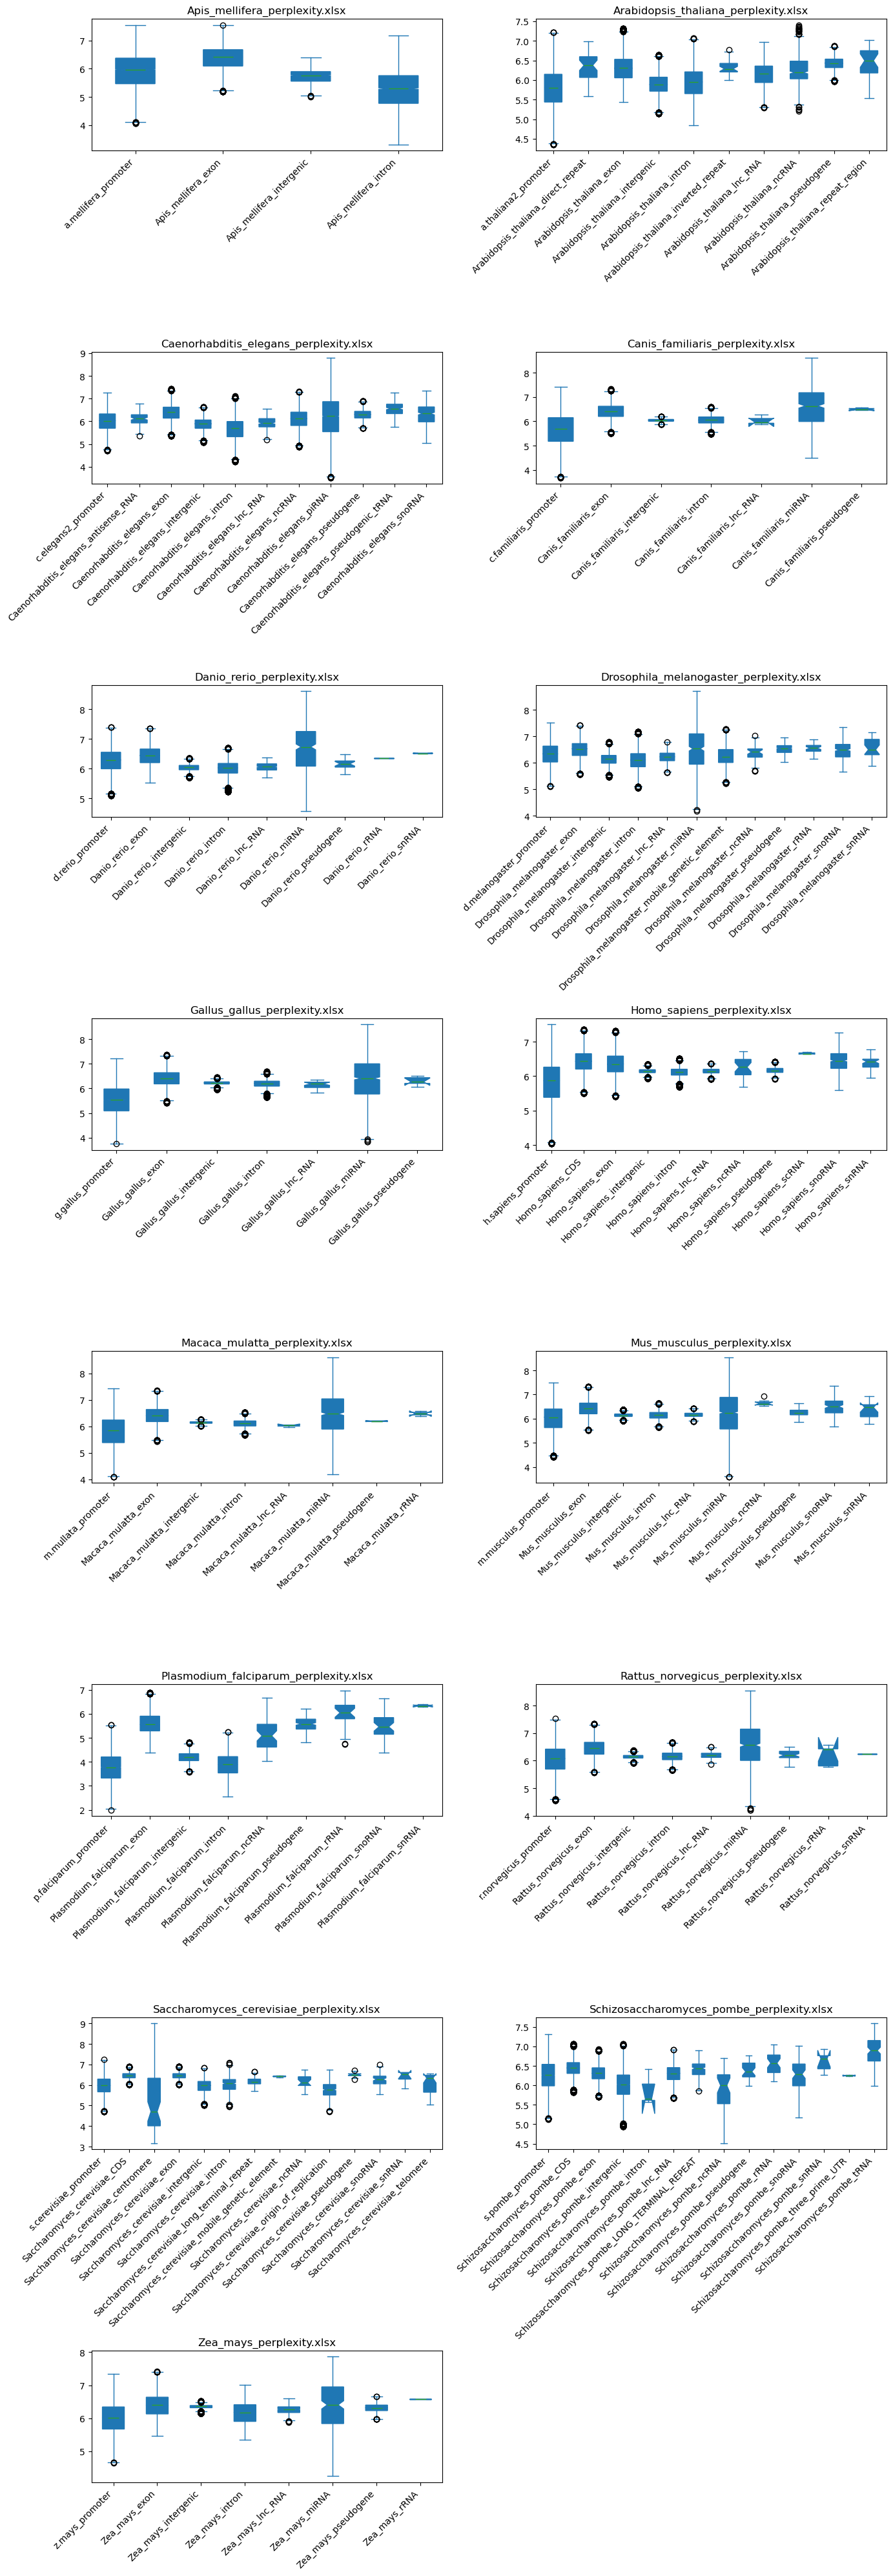

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Get list of Excel files in current directory
excel_files = [f for f in os.listdir('.') if f.endswith('.xlsx') or f.endswith('.xls')]

# Setup figure and subplots
n_files = len(excel_files)
cols = 2
rows = (n_files + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Use a color map
cmap = get_cmap("Set3")

# Function to remove outliers using IQR
def remove_outliers(df):
    cleaned = pd.DataFrame()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
            cleaned[col] = df[col][mask]
    return cleaned

# Process and plot each Excel file
for i, filename in enumerate(excel_files):
    df = pd.read_excel(filename)
    df_cleaned = remove_outliers(df)

    ax = axes[i]
    boxprops = dict(notch=True, patch_artist=True)
    bp = df_cleaned.plot.box(ax=ax, **boxprops)

    # Apply color to each box
    for patch, color in zip(bp.artists, cmap.colors):
        patch.set_facecolor(color)

    ax.set_title(filename, fontsize=12)
    ax.set_xticklabels(df_cleaned.columns, rotation=45, ha='right')

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Finalize layout
plt.tight_layout()
plt.savefig("all_boxplots.png", dpi=300)
plt.show()


C:\Users\klu\AppData\Local\Temp\ipykernel_15416\321865040.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set3")


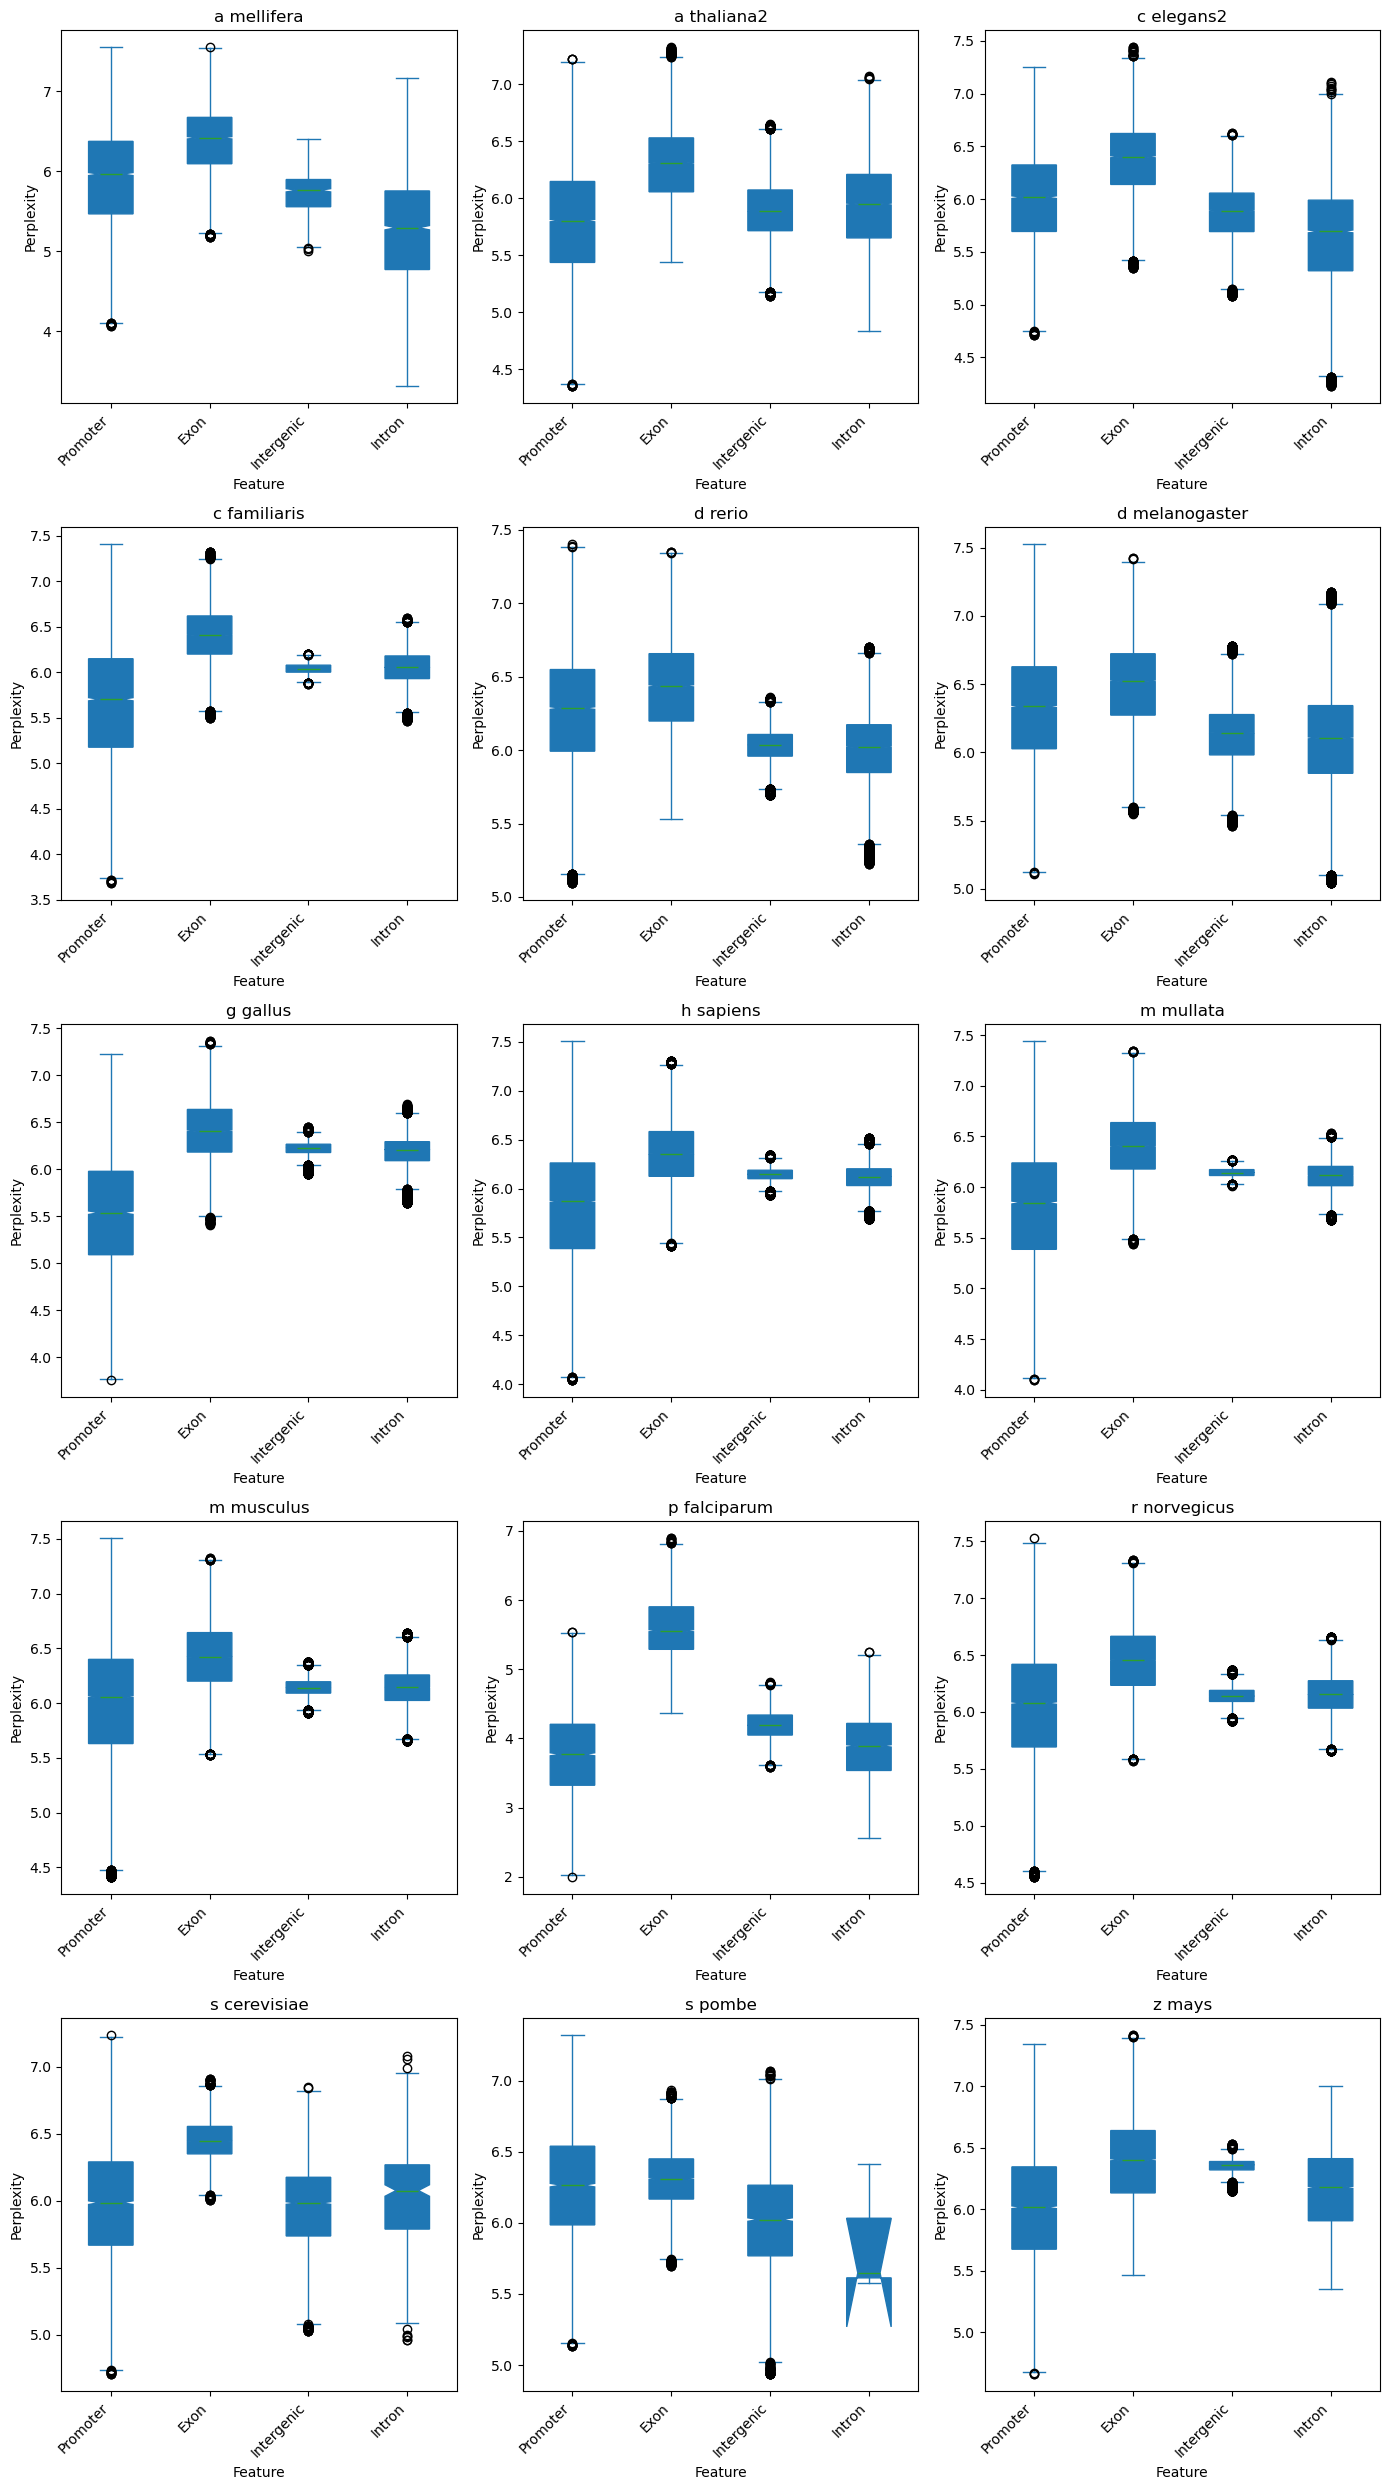

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Accepted features to include in plot
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Get list of Excel files in current directory
excel_files = [f for f in os.listdir('.') if f.endswith('.xlsx') or f.endswith('.xls')]

# Setup figure and subplots
n_files = len(excel_files)
cols = 3
rows = (n_files + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Use a color map
cmap = get_cmap("Set3")

# Function to remove outliers using IQR
def remove_outliers(df):
    cleaned = pd.DataFrame()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
            cleaned[col] = df[col][mask]
    return cleaned

# Process and plot each Excel file
for i, filename in enumerate(excel_files):
    df = pd.read_excel(filename)
    df_cleaned = remove_outliers(df)

    # Filter only desired columns based on feature
    filtered_cols = {}
    for col in df_cleaned.columns:
        col_norm = col.replace(".", "_")
        parts = col_norm.split("_")
        if len(parts) >= 3:
            genus_species = " ".join(parts[:2])
            feature = "_".join(parts[2:]).lower()
            if feature in valid_features:
                filtered_cols[col] = (genus_species, feature.capitalize())

    if not filtered_cols:
        continue  # Skip if no valid columns

    ax = axes[i]
    boxprops = dict(notch=True, patch_artist=True)

    # Subset dataframe and rename columns to just feature
    subset_df = df_cleaned[filtered_cols.keys()].rename(columns={col: feature for col, (_, feature) in filtered_cols.items()})
    bp = subset_df.plot.box(ax=ax, **boxprops)

    # Apply color to each box
    for patch, color in zip(bp.artists, cmap.colors):
        patch.set_facecolor(color)

    # Set title and axis labels
    genus_species = list(filtered_cols.values())[0][0]  # Get from first column
    ax.set_title(genus_species, fontsize=12)
    ax.set_xlabel("Feature", fontsize=10)
    ax.set_ylabel("Perplexity", fontsize=10)
    ax.set_xticklabels(subset_df.columns, rotation=45, ha='right')

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Finalize layout
plt.tight_layout()
plt.savefig("filtered_boxplots.png", dpi=300)
plt.show()


C:\Users\klu\AppData\Local\Temp\ipykernel_15416\739430161.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set3")
C:\Users\klu\AppData\Local\Temp\ipykernel_15416\739430161.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
C:\Users\klu\AppData\Local\Temp\ipykernel_15416\739430161.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
C:\Users\klu\AppData\Local\Temp\ipykernel_15416\739430161.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

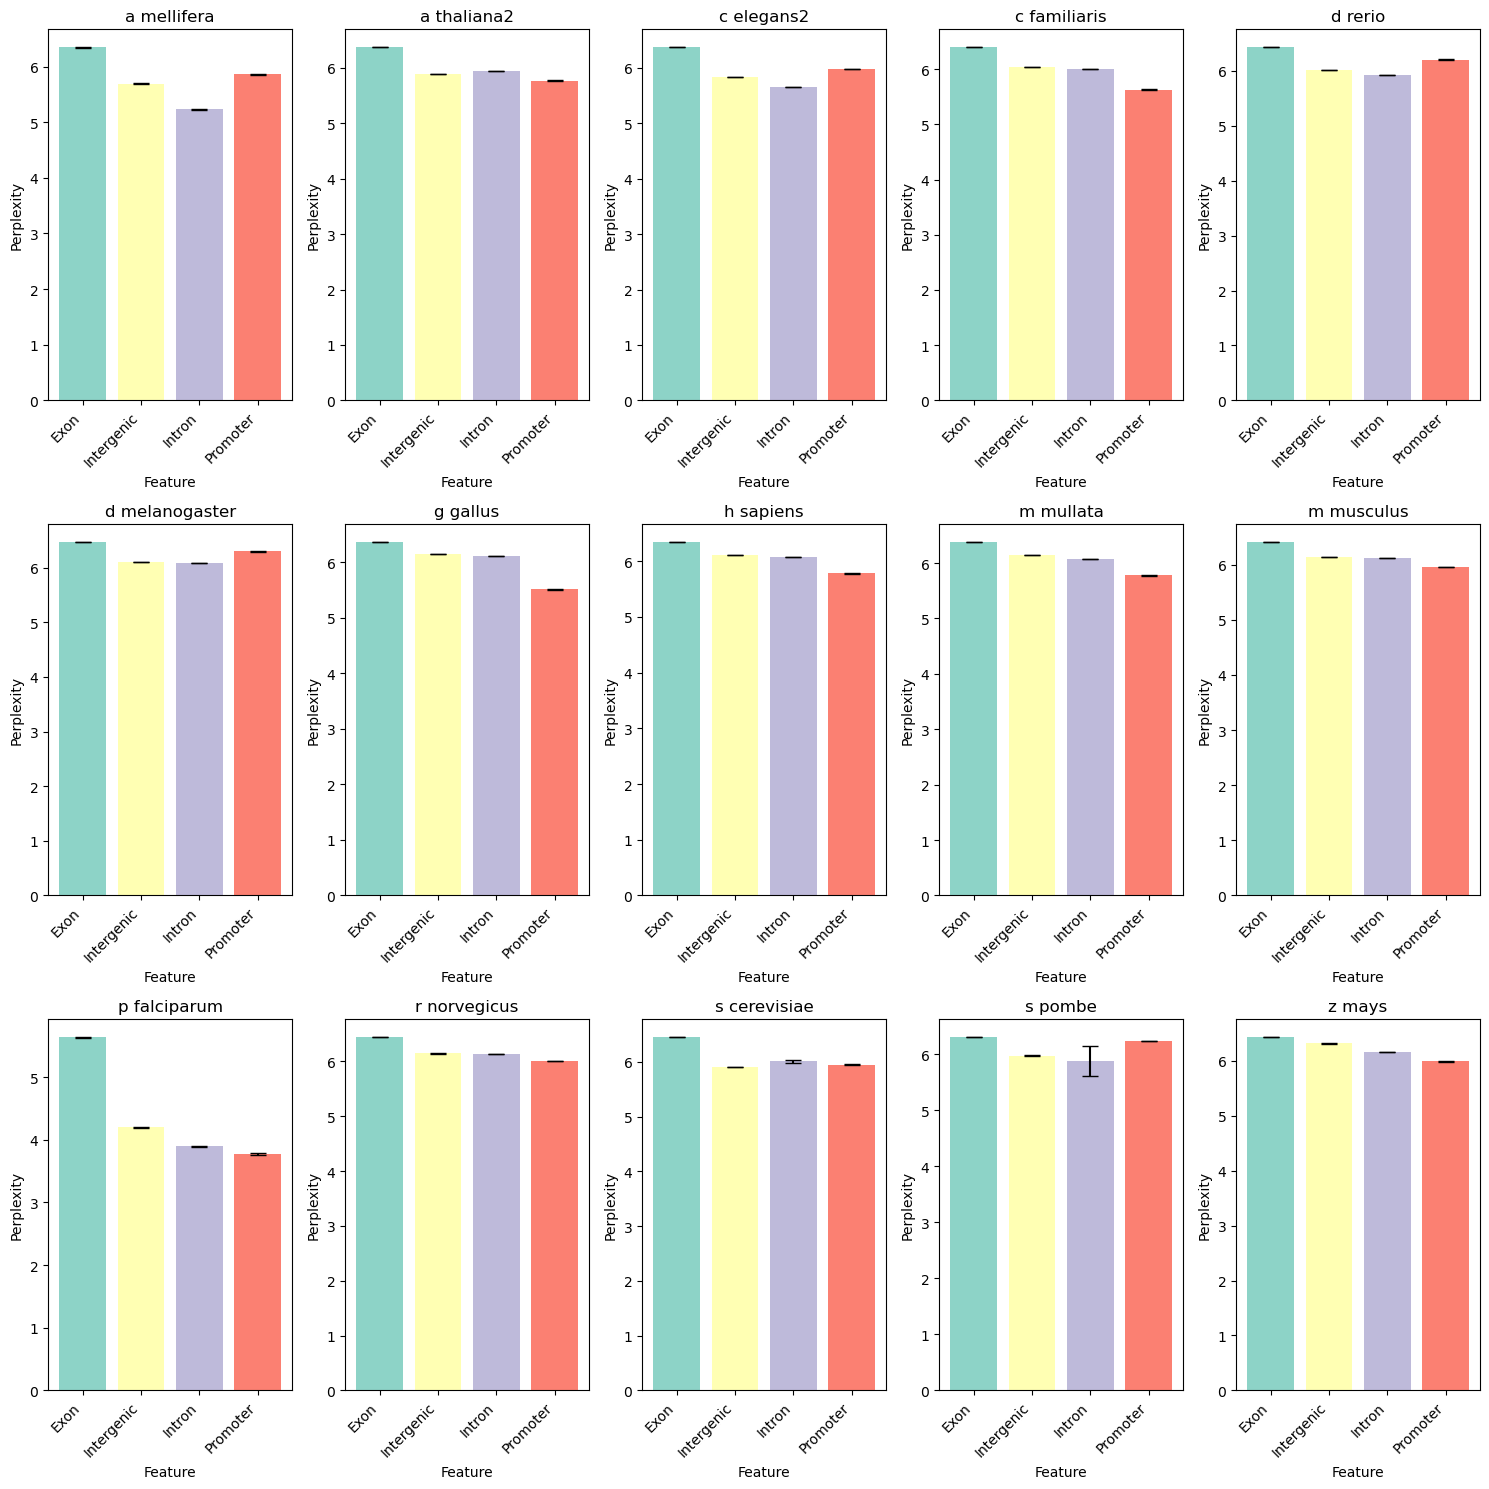

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

# Accepted features to include in plot
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Get list of Excel files in current directory
excel_files = [f for f in os.listdir('.') if f.endswith('.xlsx') or f.endswith('.xls')]

# Setup figure and subplots
n_files = len(excel_files)
cols = 5
rows = (n_files + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Color palette
cmap = get_cmap("Set3")

# Function to compute standard error
def standard_error(x):
    x = x.dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan

# Process each Excel file
for i, filename in enumerate(excel_files):
    df = pd.read_excel(filename)

    # Filter and process columns
    mean_se_data = []
    filtered_cols = {}
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
        col_norm = col.replace(".", "_")
        parts = col_norm.split("_")
        if len(parts) >= 3:
            genus_species = " ".join(parts[:2])
            feature = "_".join(parts[2:]).lower()
            if feature in valid_features:
                mean = df[col].mean(skipna=True)
                se = standard_error(df[col])
                mean_se_data.append((feature.capitalize(), mean, se))
                filtered_cols[col] = (genus_species, feature.capitalize())

    if not mean_se_data:
        continue

    # Sort features for consistent bar order
    mean_se_data.sort(key=lambda x: x[0])

    features = [x[0] for x in mean_se_data]
    means = [x[1] for x in mean_se_data]
    errors = [x[2] for x in mean_se_data]

    ax = axes[i]
    bars = ax.bar(features, means, yerr=errors, capsize=6, color=cmap.colors[:len(features)])
    genus_species = list(filtered_cols.values())[0][0]

    ax.set_title(genus_species, fontsize=12)
    ax.set_xlabel("Feature", fontsize=10)
    ax.set_ylabel("Perplexity", fontsize=10)
    ax.set_xticklabels(features, rotation=45, ha='right')

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final layout and save
plt.tight_layout()
plt.savefig("mean_se_barplots.png", dpi=300)
plt.show()


In [10]:
pip install ptitprince seaborn matplotlib pandas


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/283.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/283.1 kB ? eta -:--:--
   ----- --------------------------------- 41.0/283.1 kB 653.6 kB/s eta 0:00:01
   ------------------------ --------------- 174.1/283.1 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  276.5/283.1 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 283.1/283.1 kB 1.7 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10680 sha256=462e902b743959686f51ce9f27adedd381d465d38a47f516be325d4d8e5c2cdd
  Stored in directory: c:\users\klu\appdata\local\pip\cache\wheels\d0\5a\76\53fc6d781c06cea5c60e4c69a9ae9beca5675a7dc1206ec8bc
Successfully built ptitprince
Note: you may need to restart the kernel t

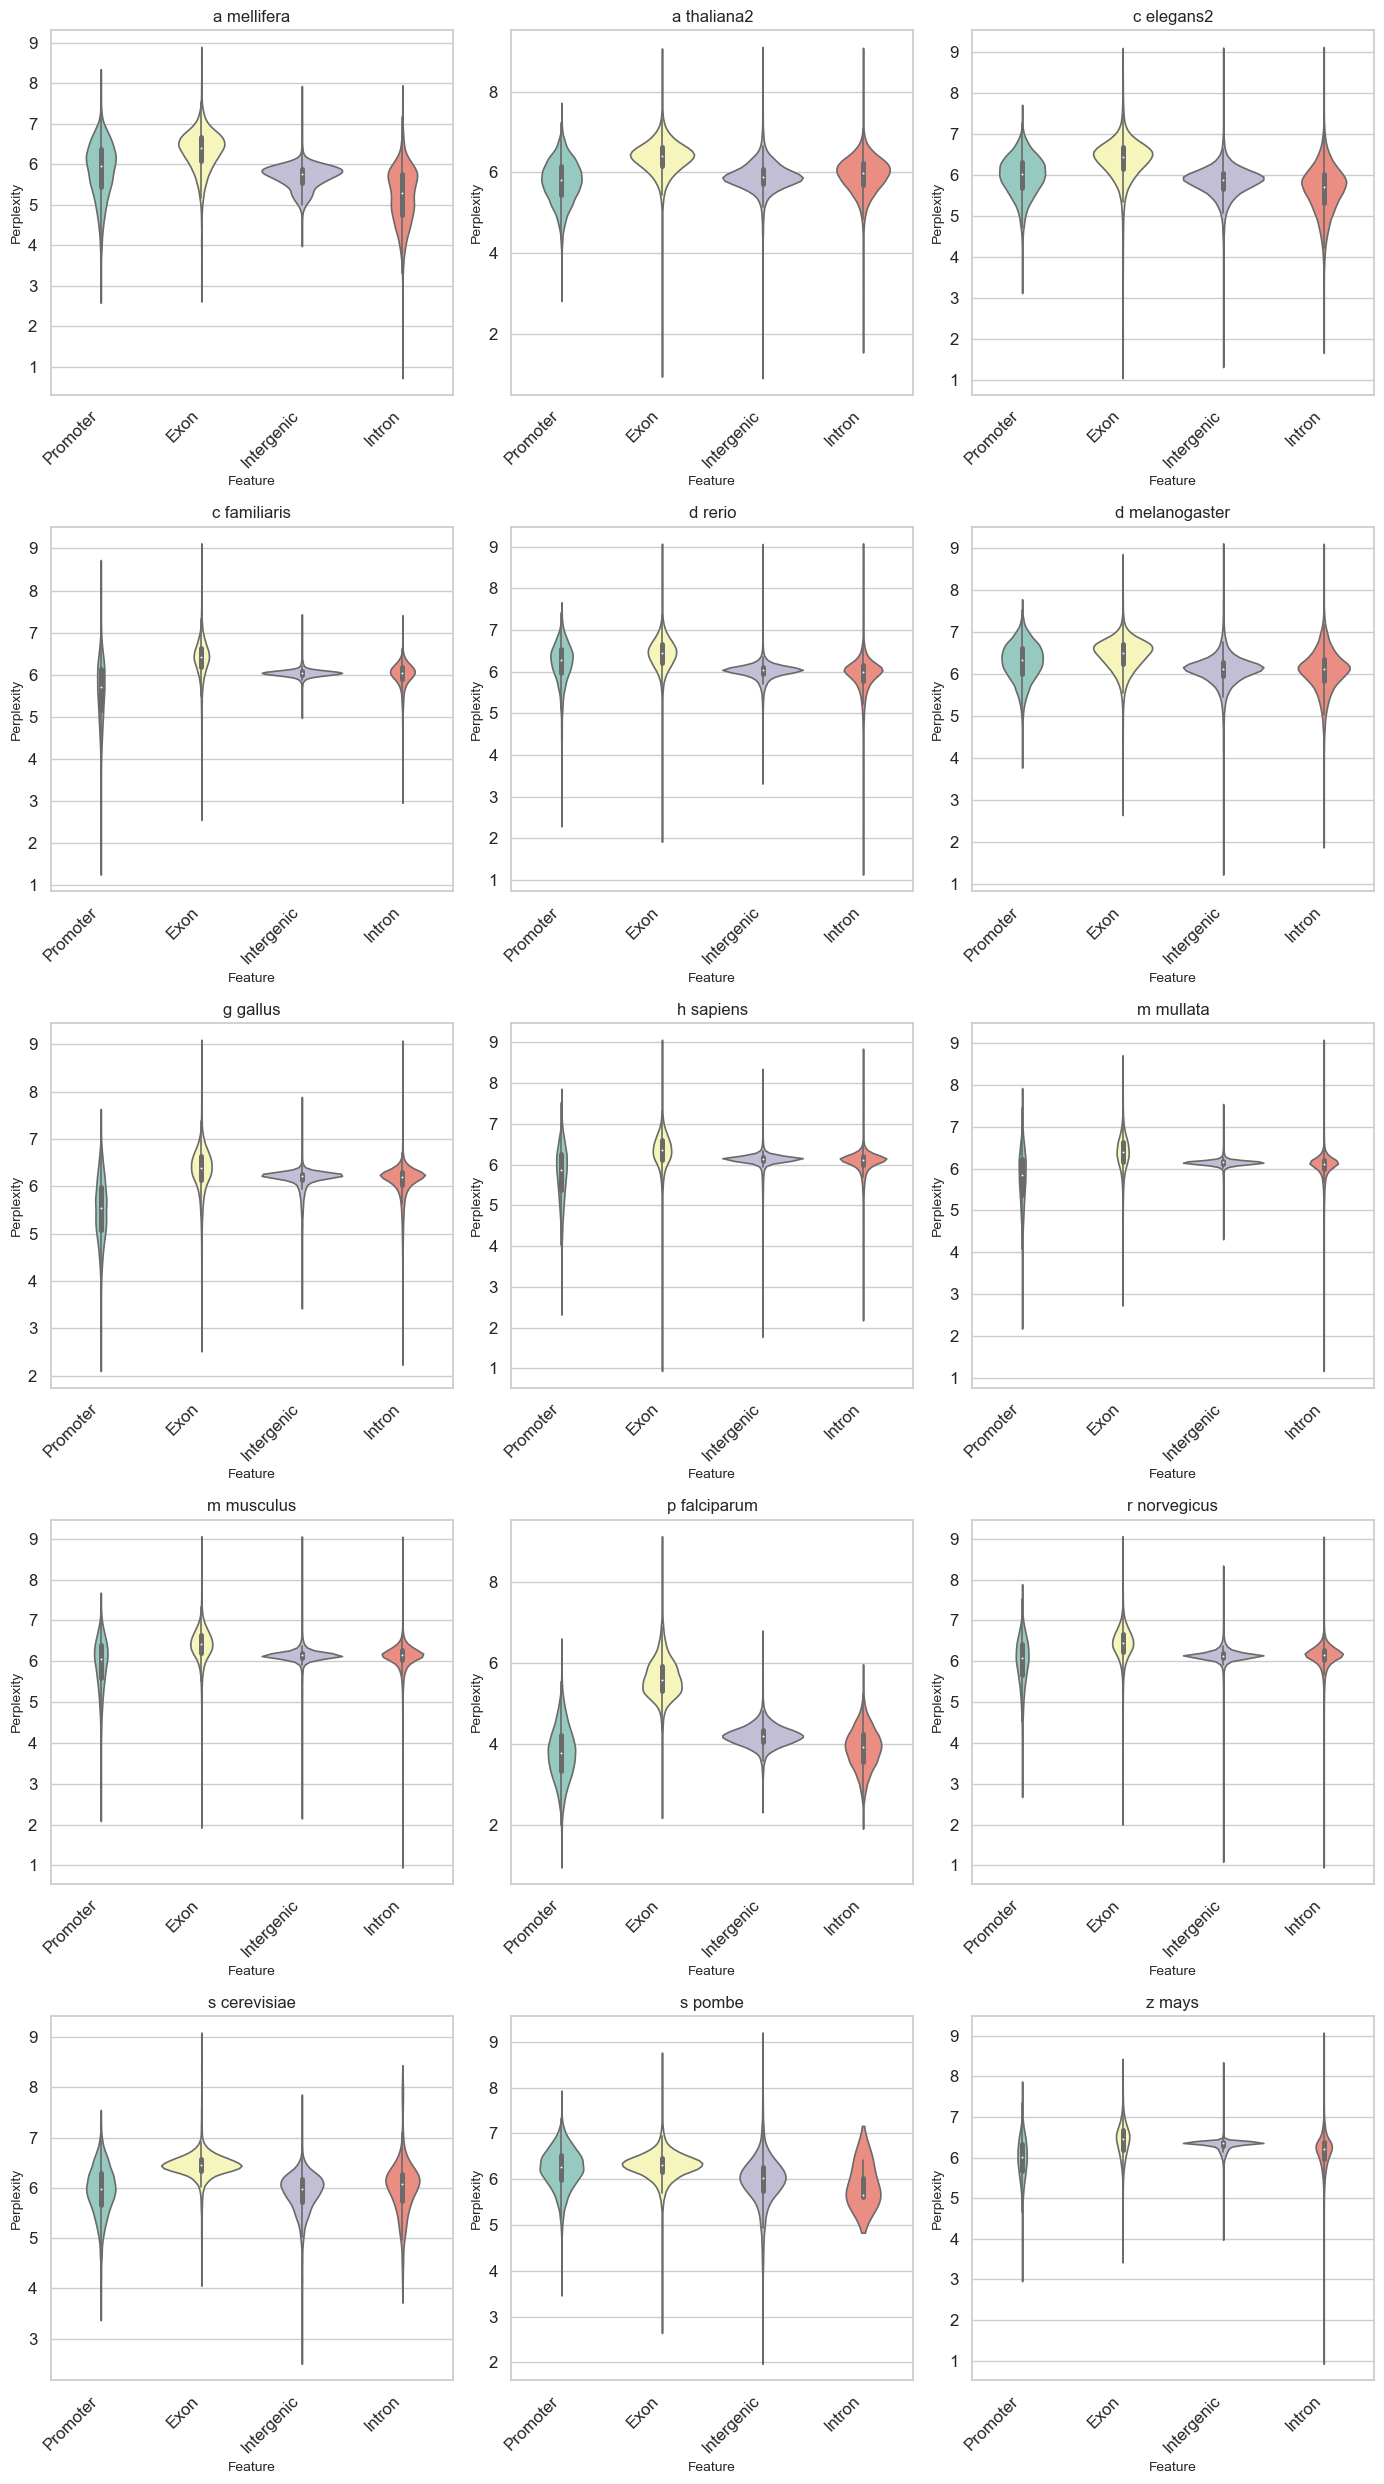

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Accepted features to include
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Get Excel files
excel_files = [f for f in os.listdir('.') if f.endswith('.xlsx') or f.endswith('.xls')]

# Setup plot grid
n_files = len(excel_files)
cols = 3
rows = (n_files + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

sns.set(style="whitegrid", palette="Set3")

# Loop through Excel files
for i, filename in enumerate(excel_files):
    df = pd.read_excel(filename)

    # Extract long-format data
    long_data = []
    for col in df.columns:
        col_norm = col.replace('.', '_')
        parts = col_norm.split("_")
        if len(parts) >= 3:
            genus_species = " ".join(parts[:2])
            feature = "_".join(parts[2:]).lower()
            if feature in valid_features and pd.api.types.is_numeric_dtype(df[col]):
                for val in df[col].dropna():
                    long_data.append({"feature": feature.capitalize(), "perplexity": val, "species": genus_species})

    if not long_data:
        continue

    long_df = pd.DataFrame(long_data)
    ax = axes[i]
    sns.violinplot(x="feature", y="perplexity", data=long_df, ax=ax, inner="box", linewidth=1.2)
    ax.set_title(long_df["species"].iloc[0], fontsize=12)
    ax.set_xlabel("Feature", fontsize=10)
    ax.set_ylabel("Perplexity", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Clean extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("violin_plots.png", dpi=300)
plt.show()


In [6]:
import os
import pandas as pd

# Features to include
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Dictionary to hold per-species data
species_data = {}

# Process each Excel file
for file in os.listdir('.'):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue
            col_norm = col.replace(".", "_")
            parts = col_norm.split("_")
            if len(parts) >= 3:
                genus_species = " ".join(parts[:2])
                feature = "_".join(parts[2:]).lower()
                if feature in valid_features:
                    rows = pd.DataFrame({
                        "feature": feature.capitalize(),
                        "perplexity": df[col].dropna()
                    })
                    if genus_species not in species_data:
                        species_data[genus_species] = []
                    species_data[genus_species].append(rows)

# Create a single Excel with multiple sheets
with pd.ExcelWriter("species_wise_perplexity.xlsx", engine='xlsxwriter') as writer:
    for species, dfs in species_data.items():
        combined_df = pd.concat(dfs, ignore_index=True)
        # Truncate sheet names to max 31 chars
        safe_name = species[:31]
        combined_df.to_excel(writer, sheet_name=safe_name, index=False)

print("✅ Saved: species_wise_perplexity.xlsx with one sheet per species.")


ModuleNotFoundError: No module named 'xlsxwriter'

In [7]:
pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/169.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/169.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/169.4 kB ? eta -:--:--
   --------- ----------------------------- 41.0/169.4 kB 326.8 kB/s eta 0:00:01
   --------------------- ----------------- 92.2/169.4 kB 581.0 kB/s eta 0:00:01
   ------------------------------------ - 163.8/169.4 kB 978.3 kB/s eta 0:00:01
   -------------------------------------- 169.4/169.4 kB 726.9 kB/s eta 0:00:00


C:\Users\klu\AppData\Local\Temp\ipykernel_15964\1603152033.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set2")
C:\Users\klu\AppData\Local\Temp\ipykernel_15964\1603152033.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, means, yerr=errors, fmt='o', capsize=6, color='black', ecolor='gray', elinewidth=2, marker='o', markersize=6)
C:\Users\klu\AppData\Local\Temp\ipykernel_15964\1603152033.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, means, yerr=errors, fmt='o', capsize=6, color='black', ecolor='gray', elinewidth=2, marker='o', m

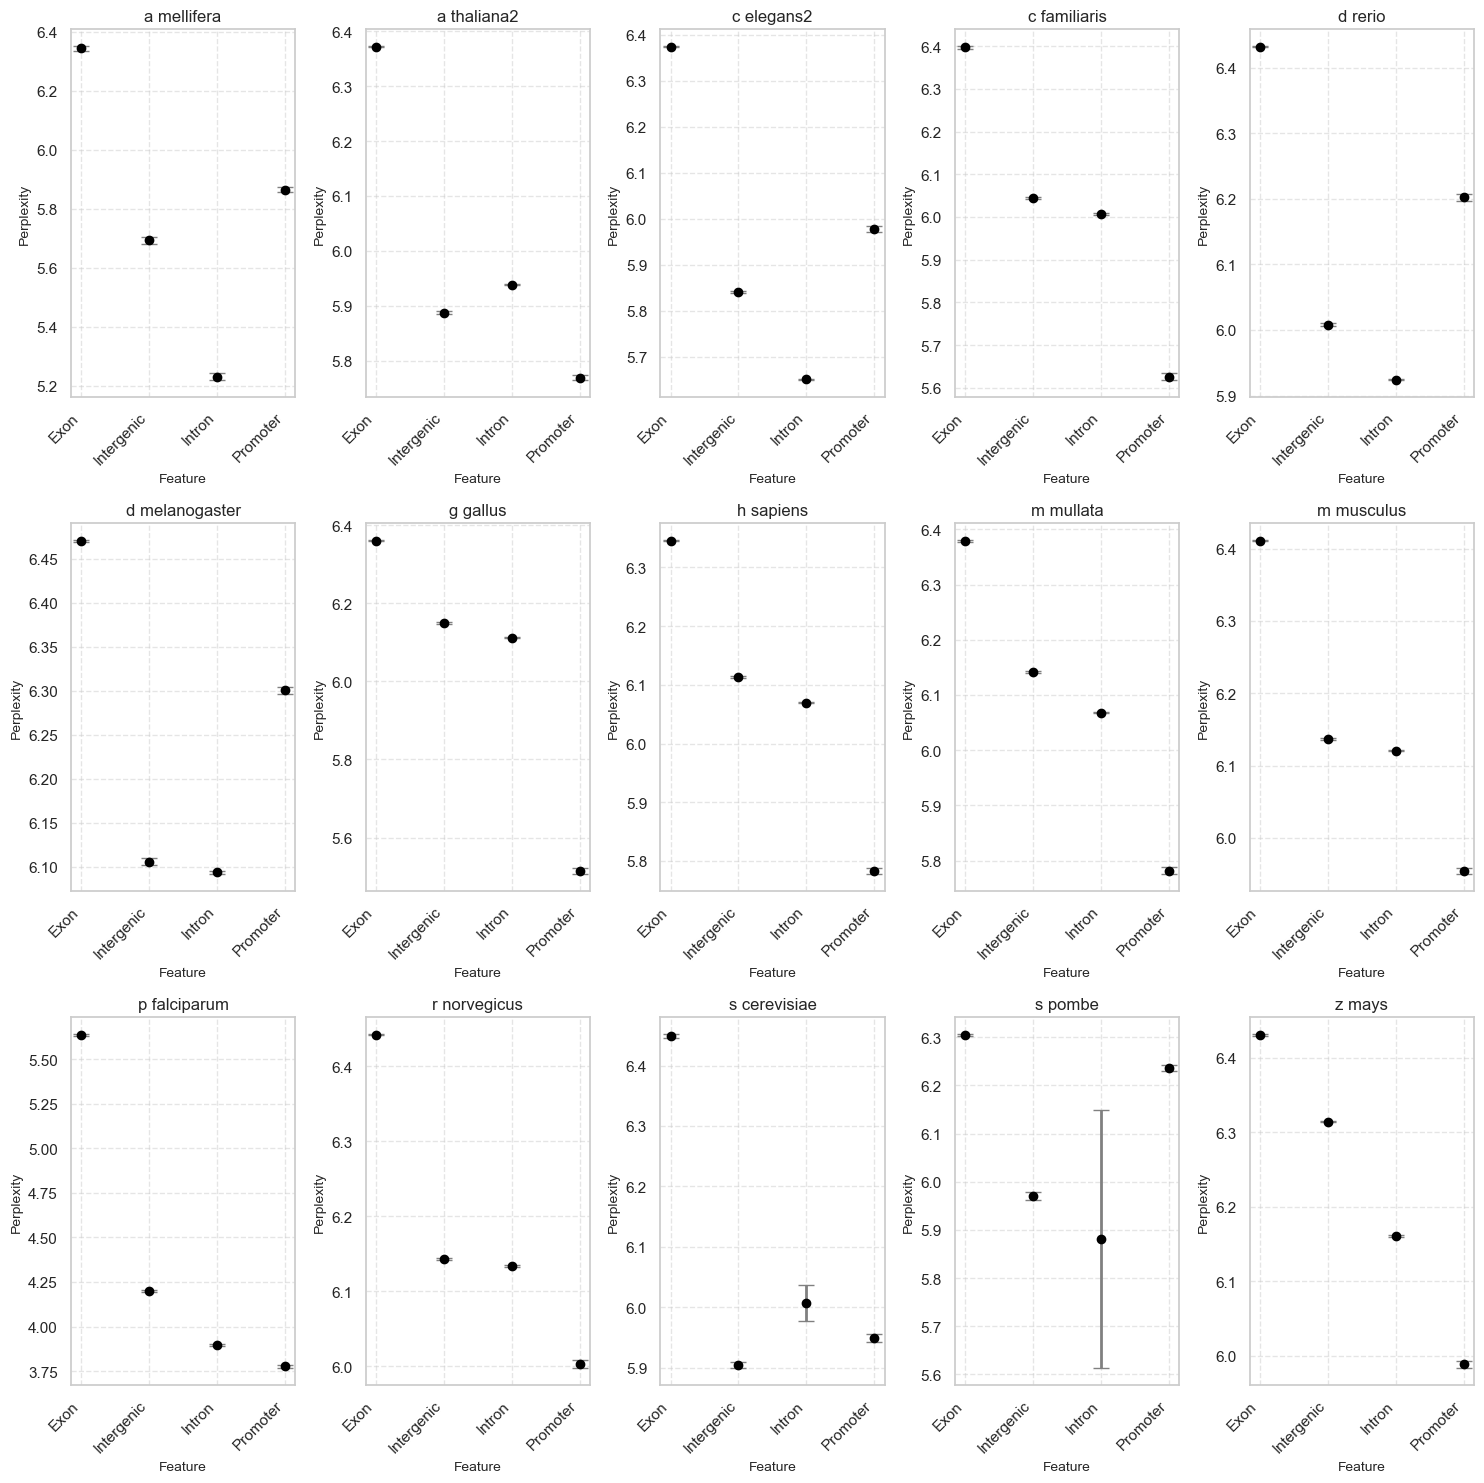

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

# Accepted features
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Excel files in current directory
excel_files = [f for f in os.listdir('.') if f.endswith('.xlsx') or f.endswith('.xls')]

# Subplot grid
cols = 5
rows = (len(excel_files) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Color map
cmap = get_cmap("Set2")

# Standard error function
def standard_error(x):
    x = x.dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan

# Process each Excel file
for i, filename in enumerate(excel_files):
    df = pd.read_excel(filename)

    mean_se_data = []
    filtered_cols = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
        col_norm = col.replace(".", "_")
        parts = col_norm.split("_")
        if len(parts) >= 3:
            genus_species = " ".join(parts[:2])
            feature = "_".join(parts[2:]).lower()
            if feature in valid_features:
                mean = df[col].mean(skipna=True)
                se = standard_error(df[col])
                mean_se_data.append((feature.capitalize(), mean, se))
                filtered_cols[col] = (genus_species, feature.capitalize())

    if not mean_se_data:
        continue

    # Sort features for consistent ordering
    mean_se_data.sort(key=lambda x: x[0])
    features = [x[0] for x in mean_se_data]
    means = [x[1] for x in mean_se_data]
    errors = [x[2] for x in mean_se_data]

    ax = axes[i]
    x = np.arange(len(features))
    ax.errorbar(x, means, yerr=errors, fmt='o', capsize=6, color='black', ecolor='gray', elinewidth=2, marker='o', markersize=6)

    genus_species = list(filtered_cols.values())[0][0]
    ax.set_title(genus_species, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.set_xlabel("Feature", fontsize=10)
    ax.set_ylabel("Perplexity", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("mean_se_point_plots.png", dpi=300)
plt.show()


In [9]:
import os
import pandas as pd

# Define features of interest
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Dictionary to collect data per species
species_data = {}

# Read Excel files in current folder
for file in os.listdir('.'):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue
            col_norm = col.replace(".", "_")
            parts = col_norm.split("_")
            if len(parts) >= 3:
                genus_species = " ".join(parts[:2])
                feature = "_".join(parts[2:]).lower()
                if feature in valid_features:
                    # Prepare entry if not exists
                    if genus_species not in species_data:
                        species_data[genus_species] = {f.capitalize(): [] for f in valid_features}
                    species_data[genus_species][feature.capitalize()].extend(df[col].dropna().tolist())

# Create Excel writer and save each species in its own sheet
with pd.ExcelWriter("perplexity_by_species.xlsx") as writer:
    for species, feature_dict in species_data.items():
        # Convert to DataFrame (align lengths)
        df_species = pd.DataFrame(dict(feature_dict))
        df_species.to_excel(writer, sheet_name=species[:31], index=False)  # Excel sheet name limit: 31 chars

print("✅ Saved: perplexity_by_species.xlsx")


ValueError: All arrays must be of the same length

In [10]:
import os
import pandas as pd
import numpy as np

# Only these features will be processed
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Dictionary: {(species, feature): [values]}
data = {}

# Read all Excel files in current folder
for file in os.listdir('.'):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue
            col_norm = col.replace(".", "_")
            parts = col_norm.split("_")
            if len(parts) >= 3:
                species = " ".join(parts[:2])
                feature = "_".join(parts[2:]).lower()
                if feature in valid_features:
                    key = (species, feature.capitalize())
                    data.setdefault(key, []).extend(df[col].dropna().tolist())

# Get unique feature names and first 4 species
features = sorted({f.capitalize() for _, f in data.keys() if f.lower() in valid_features})
species_list = sorted({s for s, _ in data.keys()})[:4]  # Limit to 4 species

# Create final DataFrame
rows = []
for feature in features:
    row = {"feature": feature}
    for species in species_list:
        values = data.get((species, feature), [])
        if values:
            mean = np.mean(values)
            stderr = np.std(values, ddof=1) / np.sqrt(len(values))
            row[f"{species}_mean"] = round(mean, 4)
            row[f"{species}_se"] = round(stderr, 4)
        else:
            row[f"{species}_mean"] = np.nan
            row[f"{species}_se"] = np.nan
    rows.append(row)

# Save to Excel
summary_df = pd.DataFrame(rows)
summary_df.to_excel("perplexity_summary_4species.xlsx", index=False)
print("✅ Saved: perplexity_summary_4species.xlsx")


✅ Saved: perplexity_summary_4species.xlsx


In [11]:
import os
import pandas as pd
import numpy as np

# Define features of interest
valid_features = {"promoter", "exon", "intron", "intergenic"}

# Dictionary to collect data
data = {}

# Read Excel files in current directory
for file in os.listdir('.'):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        df = pd.read_excel(file)
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                continue
            col_norm = col.replace(".", "_")
            parts = col_norm.split("_")
            if len(parts) >= 3:
                species = " ".join(parts[:2])
                feature = "_".join(parts[2:]).lower()
                if feature in valid_features:
                    key = (species, feature.capitalize())
                    data.setdefault(key, []).extend(df[col].dropna().tolist())

# Get all species and features
species_list = sorted({s for s, _ in data.keys()})
features = sorted({f.capitalize() for _, f in data.keys()})

# Create a wide-format summary
rows = []
for species in species_list:
    row = {"species": species}
    for feature in features:
        values = data.get((species, feature), [])
        if values:
            mean = np.mean(values)
            se = np.std(values, ddof=1) / np.sqrt(len(values))
            row[f"{feature}_mean"] = round(mean, 4)
            row[f"{feature}_se"] = round(se, 4)
        else:
            row[f"{feature}_mean"] = np.nan
            row[f"{feature}_se"] = np.nan
    rows.append(row)

# Save to Excel
df_wide = pd.DataFrame(rows)
df_wide.to_excel("perplexity_summary_wide_format.xlsx", index=False)
print("✅ Saved: perplexity_summary_wide_format.xlsx")


✅ Saved: perplexity_summary_wide_format.xlsx


In [9]:
# Ensure you have this installed: pip install statannotations seaborn pandas numpy matplotlib scipy openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare
import numpy as np
import os
from statannotations.Annotator import Annotator

# Load data
df = pd.read_excel("merged_perplexity_columns.xlsx")

# Create output directories
os.makedirs("publication_plots", exist_ok=True)

# Detect species column groups
column_groups = {}
for col in df.columns:
    if col.endswith("_promoter"):
        base = col.replace("_promoter", "")
        expected = [f"{base}_{x}" for x in ["promoter", "exon", "intron", "intergenic"]]
        if all(c in df.columns for c in expected):
            column_groups[base] = dict(zip(["promoter", "exon", "intron", "intergenic"], expected))

# Store results
summary_data = []
exploratory_summary = []

def cohens_d(x, y):
    diff = x - y
    return diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) != 0 else np.nan

# Plot layout
n_species = len(column_groups)
ncols = 4
nrows = int(np.ceil(n_species / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)
axes = axes.flatten()

# Analysis
for idx, (species, cols) in enumerate(column_groups.items()):
    region_data = {k: df[v].dropna().reset_index(drop=True) for k, v in cols.items()}
    min_len = min(len(v) for v in region_data.values())
    if min_len < 3:
        continue
    for k in region_data:
        region_data[k] = region_data[k][:min_len]
    data = pd.DataFrame(region_data)
    melted = data.melt(var_name="Region", value_name="Perplexity")

    # Plotting with annotations
    ax = axes[idx]
    sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)
    sns.stripplot(x="Region", y="Perplexity", data=melted, color='black', alpha=0.3, jitter=True, ax=ax)
    ax.set_title(species.replace("_", " "), fontsize=10)
    pairs = [("promoter", "exon"), ("promoter", "intron"), ("promoter", "intergenic")]
    annotator = Annotator(ax, pairs, data=melted, x="Region", y="Perplexity")
    annotator.configure(test="t-test_paired", text_format="full", loc="outside", comparisons_correction=None)
    annotator.apply_and_annotate()

    # Friedman test
    try:
        f_stat, f_p = friedmanchisquare(data["promoter"], data["exon"], data["intron"], data["intergenic"])
    except:
        f_p = np.nan

    for region in ["exon", "intron", "intergenic"]:
        x = data["promoter"]
        y = data[region]
        t_stat, t_p = ttest_rel(x, y)
        try:
            w_stat, w_p = wilcoxon(x, y)
        except:
            w_p = np.nan
        d = cohens_d(x, y)
        summary_data.append({
            "Species": species,
            "Comparison": f"promoter vs {region}",
            "T-test p": round(t_p, 6),
            "Wilcoxon p": round(w_p, 6) if not pd.isna(w_p) else "NA",
            "Cohen's d": round(d, 4),
            "Friedman p": round(f_p, 6),
            "Promoter Mean": x.mean(),
            f"{region} Mean": y.mean()
        })

    exploratory_summary.append({
        "Species": species,
        "Promoter Mean": round(data["promoter"].mean(), 3),
        "Promoter SD": round(data["promoter"].std(), 3),
        "Promoter < Exon %": round((data["promoter"] < data["exon"]).mean() * 100, 1),
        "Promoter < Intron %": round((data["promoter"] < data["intron"]).mean() * 100, 1),
        "Promoter < Intergenic %": round((data["promoter"] < data["intergenic"]).mean() * 100, 1),
    })

# Save figure
plt.suptitle("Promoter vs Other Genomic Features – Perplexity Comparison", fontsize=16)
plt.savefig("publication_plots/multi_panel_comparison.png", dpi=600)
plt.close()

# Save Excel outputs
pd.DataFrame(summary_data).to_excel("publication_plots/statistical_results_detailed.xlsx", index=False)
pd.DataFrame(exploratory_summary).to_excel("publication_plots/exploratory_summary.xlsx", index=False)

print("✅ All done: high-res plots, stats, and summaries saved in 'publication_plots/'")


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:1.397e-41 t=-1.446e+01
promoter vs. intron: t-test paired samples, P_val:1.427e-39 t=1.404e+01
promoter vs. intergenic: t-test paired samples, P_val:1.462e-06 t=4.859e+00


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-7.682e+01
promoter vs. intron: t-test paired samples, P_val:4.480e-92 t=-2.054e+01
promoter vs. intergenic: t-test paired samples, P_val:1.692e-68 t=-1.761e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-4.581e+01
promoter vs. intron: t-test paired samples, P_val:2.035e-279 t=3.759e+01
promoter vs. intergenic: t-test paired samples, P_val:1.637e-59 t=1.644e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-4.805e+01
promoter vs. intron: t-test paired samples, P_val:1.222e-152 t=-2.821e+01
promoter vs. intergenic: t-test paired samples, P_val:2.721e-181 t=-3.120e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:9.499e-201 t=-3.092e+01
promoter vs. intron: t-test paired samples, P_val:3.583e-226 t=3.293e+01
promoter vs. intergenic: t-test paired samples, P_val:1.223e-246 t=3.449e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:1.201e-202 t=-3.098e+01
promoter vs. intron: t-test paired samples, P_val:0.000e+00 t=4.014e+01
promoter vs. intergenic: t-test paired samples, P_val:5.287e-250 t=3.460e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-8.477e+01
promoter vs. intron: t-test paired samples, P_val:0.000e+00 t=-5.782e+01
promoter vs. intergenic: t-test paired samples, P_val:0.000e+00 t=-6.772e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-9.206e+01
promoter vs. intron: t-test paired samples, P_val:0.000e+00 t=-5.398e+01
promoter vs. intergenic: t-test paired samples, P_val:0.000e+00 t=-5.968e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-6.269e+01
promoter vs. intron: t-test paired samples, P_val:3.479e-92 t=-2.072e+01
promoter vs. intergenic: t-test paired samples, P_val:0.000e+00 t=-4.335e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-8.482e+01
promoter vs. intron: t-test paired samples, P_val:4.348e-82 t=-1.928e+01
promoter vs. intergenic: t-test paired samples, P_val:2.608e-310 t=-3.836e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-1.431e+02
promoter vs. intron: t-test paired samples, P_val:1.073e-13 t=-7.458e+00
promoter vs. intergenic: t-test paired samples, P_val:2.502e-257 t=-3.693e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:0.000e+00 t=-6.872e+01
promoter vs. intron: t-test paired samples, P_val:1.744e-12 t=-7.061e+00
promoter vs. intergenic: t-test paired samples, P_val:1.766e-137 t=-2.528e+01


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:2.729e-29 t=-1.244e+01
promoter vs. intron: t-test paired samples, P_val:8.072e-02 t=-1.752e+00
promoter vs. intergenic: t-test paired samples, P_val:1.149e-03 t=3.281e+00


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\104698878.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Perplexity", data=melted, palette="pastel", ax=ax)


promoter vs. exon: t-test paired samples, P_val:6.817e-01 t=4.749e-01
promoter vs. intron: t-test paired samples, P_val:4.276e-01 t=9.873e-01
promoter vs. intergenic: t-test paired samples, P_val:9.689e-02 t=2.974e+00
✅ All done: high-res plots, stats, and summaries saved in 'publication_plots/'


In [10]:
# Required Libraries
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu, friedmanchisquare
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings("ignore")

# Load data
file = "merged_perplexity_columns.xlsx"
df = pd.read_excel(file)

# Output folder
output_dir = "validation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Group detection
column_groups = {}
for col in df.columns:
    if col.endswith("_promoter"):
        base = col.replace("_promoter", "")
        expected = [f"{base}_{x}" for x in ["promoter", "exon", "intron", "intergenic"]]
        if all(c in df.columns for c in expected):
            column_groups[base] = dict(zip(["promoter", "exon", "intron", "intergenic"], expected))

# Utilities
def cohens_d(x, y):
    pooled_std = np.sqrt(((x.std(ddof=1) ** 2) + (y.std(ddof=1) ** 2)) / 2)
    return (x.mean() - y.mean()) / pooled_std if pooled_std != 0 else np.nan

# Outputs
summary_table = []
detailed_stats = []
auc_results = []

# Loop over species
for species, cols in column_groups.items():
    region_data = {k: df[v].dropna().reset_index(drop=True) for k, v in cols.items()}
    
    # Summary for each region
    for region, values in region_data.items():
        summary_table.append({
            "Species": species,
            "Region": region,
            "Count": len(values),
            "Mean": values.mean(),
            "Median": values.median(),
            "Std Dev": values.std(ddof=1),
            "Std Error": values.std(ddof=1) / np.sqrt(len(values)) if len(values) > 0 else np.nan
        })

    # Paired testing (min length check)
    min_len = min(len(v) for v in region_data.values())
    if min_len < 3:
        continue
    paired_data = {k: v[:min_len] for k, v in region_data.items()}
    paired_df = pd.DataFrame(paired_data)

    try:
        _, f_p = friedmanchisquare(paired_df["promoter"], paired_df["exon"],
                                   paired_df["intron"], paired_df["intergenic"])
    except:
        f_p = np.nan

    for region in ["exon", "intron", "intergenic"]:
        # Paired tests
        t_paired = ttest_rel(paired_df["promoter"], paired_df[region]).pvalue
        try:
            w_paired = wilcoxon(paired_df["promoter"], paired_df[region]).pvalue
        except:
            w_paired = np.nan

        # Unpaired tests
        t_unpaired = ttest_ind(region_data["promoter"], region_data[region], equal_var=False).pvalue
        try:
            u_p = mannwhitneyu(region_data["promoter"], region_data[region]).pvalue
        except:
            u_p = np.nan

        # Effect size
        d = cohens_d(region_data["promoter"], region_data[region])

        detailed_stats.append({
            "Species": species,
            "Comparison": f"promoter vs {region}",
            "Paired T-test p": round(t_paired, 6),
            "Wilcoxon p": round(w_paired, 6) if not pd.isna(w_paired) else "NA",
            "Unpaired T-test p": round(t_unpaired, 6),
            "Mann-Whitney p": round(u_p, 6) if not pd.isna(u_p) else "NA",
            "Cohen's d": round(d, 4),
            "Friedman p": round(f_p, 6)
        })

    # AUC analysis
    if all(len(region_data[r]) >= 3 for r in region_data):
        all_vals = np.concatenate([
            region_data["promoter"],
            region_data["exon"],
            region_data["intron"],
            region_data["intergenic"]
        ])
        labels = np.array([1]*len(region_data["promoter"]) + [0]*(len(region_data["exon"]) + len(region_data["intron"]) + len(region_data["intergenic"])))
        X = all_vals.reshape(-1, 1)
        try:
            auc = cross_val_score(LogisticRegression(), X, labels, cv=5, scoring='roc_auc')
            auc_results.append({
                "Species": species,
                "Mean AUC": round(auc.mean(), 4),
                "Std AUC": round(auc.std(), 4)
            })
        except:
            auc_results.append({
                "Species": species,
                "Mean AUC": "Failed",
                "Std AUC": "NA"
            })

# Save Excel outputs
pd.DataFrame(summary_table).to_excel(f"{output_dir}/region_summary_statistics.xlsx", index=False)
pd.DataFrame(detailed_stats).to_excel(f"{output_dir}/comparative_statistics.xlsx", index=False)
pd.DataFrame(auc_results).to_excel(f"{output_dir}/auc_results.xlsx", index=False)

print("✅ Completed. Results saved in:", output_dir)


✅ Completed. Results saved in: validation_outputs


In [12]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu, friedmanchisquare, ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings("ignore")

# Load data
file = "merged_perplexity_columns.xlsx"
df = pd.read_excel(file)

# Output folder
output_dir = "validation_outputs_hypothesis"
os.makedirs(output_dir, exist_ok=True)

# Detect groupings
column_groups = {}
for col in df.columns:
    if col.endswith("_promoter"):
        base = col.replace("_promoter", "")
        expected = [f"{base}_{x}" for x in ["promoter", "exon", "intron", "intergenic"]]
        if all(c in df.columns for c in expected):
            column_groups[base] = dict(zip(["promoter", "exon", "intron", "intergenic"], expected))

# Utility
def cohens_d(x, y):
    pooled_std = np.sqrt(((x.std(ddof=1) ** 2) + (y.std(ddof=1) ** 2)) / 2)
    return (x.mean() - y.mean()) / pooled_std if pooled_std != 0 else np.nan

# Outputs
summary_table = []
detailed_stats = []
auc_results = []

for species, cols in column_groups.items():
    region_data = {k: df[v].dropna().reset_index(drop=True) for k, v in cols.items()}

    for region, values in region_data.items():
        summary_table.append({
            "Species": species,
            "Region": region,
            "Count": len(values),
            "Mean": values.mean(),
            "Median": values.median(),
            "Std Dev": values.std(ddof=1),
            "Std Error": values.std(ddof=1) / np.sqrt(len(values)) if len(values) > 0 else np.nan
        })

    # Ensure enough data
    min_len = min(len(v) for v in region_data.values())
    if min_len < 3:
        continue

    paired_data = {k: v[:min_len] for k, v in region_data.items()}
    paired_df = pd.DataFrame(paired_data)

    try:
        _, f_p = friedmanchisquare(paired_df["promoter"], paired_df["exon"],
                                   paired_df["intron"], paired_df["intergenic"])
    except:
        f_p = np.nan

    for region in ["exon", "intron", "intergenic"]:
        promoter = paired_df["promoter"]
        other = paired_df[region]

        # Paired one-sided t-test
        t_stat, t_p = ttest_rel(promoter, other)
        t_p = t_p / 2 if t_stat < 0 else 1.0

        # Wilcoxon one-sided (promoter < other)
        try:
            w_stat, w_p = wilcoxon(promoter, other, alternative='less')
        except:
            w_p = np.nan

        # Unpaired t-test one-sided
        t_stat_u, t_p_u = ttest_ind(region_data["promoter"], region_data[region], equal_var=False)
        t_p_u = t_p_u / 2 if t_stat_u < 0 else 1.0

        # Mann-Whitney one-sided
        try:
            u_stat, u_p = mannwhitneyu(region_data["promoter"], region_data[region], alternative="less")
        except:
            u_p = np.nan

        # KS-test one-sided (promoter < region)
        try:
            ks_stat, ks_p = ks_2samp(region_data["promoter"], region_data[region], alternative="less")
        except:
            ks_p = np.nan

        # Effect size
        d = cohens_d(region_data["promoter"], region_data[region])

        detailed_stats.append({
            "Species": species,
            "Comparison": f"promoter vs {region}",
            "Paired T-test p (one-sided)": round(t_p, 6),
            "Wilcoxon p (one-sided)": round(w_p, 6) if not pd.isna(w_p) else "NA",
            "Unpaired T-test p (one-sided)": round(t_p_u, 6),
            "Mann-Whitney p (one-sided)": round(u_p, 6) if not pd.isna(u_p) else "NA",
            "KS-test p (one-sided)": round(ks_p, 6),
            "Cohen's d": round(d, 4),
            "Friedman p": round(f_p, 6),
            "Promoter Mean": round(promoter.mean(), 4),
            f"{region} Mean": round(other.mean(), 4),
            "Promoter < Region": promoter.mean() < other.mean()
        })

    # AUC analysis
    if all(len(region_data[r]) >= 3 for r in region_data):
        all_vals = np.concatenate([
            region_data["promoter"],
            region_data["exon"],
            region_data["intron"],
            region_data["intergenic"]
        ])
        labels = np.array([1]*len(region_data["promoter"]) +
                          [0]*(len(region_data["exon"]) + len(region_data["intron"]) + len(region_data["intergenic"])))
        X = all_vals.reshape(-1, 1)
        try:
            auc = cross_val_score(LogisticRegression(), X, labels, cv=5, scoring='roc_auc')
            auc_results.append({
                "Species": species,
                "Mean AUC": round(auc.mean(), 4),
                "Std AUC": round(auc.std(), 4)
            })
        except:
            auc_results.append({
                "Species": species,
                "Mean AUC": "Failed",
                "Std AUC": "NA"
            })

# Save results
pd.DataFrame(summary_table).to_excel(f"{output_dir}/region_summary_statistics.xlsx", index=False)
pd.DataFrame(detailed_stats).to_excel(f"{output_dir}/directional_tests_promoter_lower.xlsx", index=False)
pd.DataFrame(auc_results).to_excel(f"{output_dir}/auc_scores.xlsx", index=False)

print("✅ Hypothesis-driven statistical tests complete. Results saved in:", output_dir)


✅ Hypothesis-driven statistical tests complete. Results saved in: validation_outputs_hypothesis


In [14]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu, friedmanchisquare, ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# Load data
file = "merged_perplexity_columns.xlsx"
df = pd.read_excel(file)

# Output folder
output_dir = "validation_outputs_hypothesis_cutoffs"
os.makedirs(output_dir, exist_ok=True)

# Detect groupings
column_groups = {}
for col in df.columns:
    if col.endswith("_promoter"):
        base = col.replace("_promoter", "")
        expected = [f"{base}_{x}" for x in ["promoter", "exon", "intron", "intergenic"]]
        if all(c in df.columns for c in expected):
            column_groups[base] = dict(zip(["promoter", "exon", "intron", "intergenic"], expected))

# Utility
def cohens_d(x, y):
    pooled_std = np.sqrt(((x.std(ddof=1) ** 2) + (y.std(ddof=1) ** 2)) / 2)
    return (x.mean() - y.mean()) / pooled_std if pooled_std != 0 else np.nan

# Outputs
summary_table = []
detailed_stats = []
auc_results = []
cutoff_results = []

for species, cols in column_groups.items():
    region_data = {k: df[v].dropna().reset_index(drop=True) for k, v in cols.items()}

    for region, values in region_data.items():
        summary_table.append({
            "Species": species,
            "Region": region,
            "Count": len(values),
            "Mean": values.mean(),
            "Median": values.median(),
            "Std Dev": values.std(ddof=1),
            "Std Error": values.std(ddof=1) / np.sqrt(len(values)) if len(values) > 0 else np.nan
        })

    # Ensure enough data
    min_len = min(len(v) for v in region_data.values())
    if min_len < 3:
        continue

    paired_data = {k: v[:min_len] for k, v in region_data.items()}
    paired_df = pd.DataFrame(paired_data)

    try:
        _, f_p = friedmanchisquare(paired_df["promoter"], paired_df["exon"],
                                   paired_df["intron"], paired_df["intergenic"])
    except:
        f_p = np.nan

    for region in ["exon", "intron", "intergenic"]:
        promoter = paired_df["promoter"]
        other = paired_df[region]

        # Paired one-sided t-test
        t_stat, t_p = ttest_rel(promoter, other)
        t_p = t_p / 2 if t_stat < 0 else 1.0

        # Wilcoxon one-sided (promoter < other)
        try:
            w_stat, w_p = wilcoxon(promoter, other, alternative='less')
        except:
            w_p = np.nan

        # Unpaired t-test one-sided
        t_stat_u, t_p_u = ttest_ind(region_data["promoter"], region_data[region], equal_var=False)
        t_p_u = t_p_u / 2 if t_stat_u < 0 else 1.0

        # Mann-Whitney one-sided
        try:
            u_stat, u_p = mannwhitneyu(region_data["promoter"], region_data[region], alternative="less")
        except:
            u_p = np.nan

        # KS-test one-sided (promoter < region)
        try:
            ks_stat, ks_p = ks_2samp(region_data["promoter"], region_data[region], alternative="less")
        except:
            ks_p = np.nan

        # Effect size
        d = cohens_d(region_data["promoter"], region_data[region])

        detailed_stats.append({
            "Species": species,
            "Comparison": f"promoter vs {region}",
            "Paired T-test p (one-sided)": round(t_p, 6),
            "Wilcoxon p (one-sided)": round(w_p, 6) if not pd.isna(w_p) else "NA",
            "Unpaired T-test p (one-sided)": round(t_p_u, 6),
            "Mann-Whitney p (one-sided)": round(u_p, 6) if not pd.isna(u_p) else "NA",
            "KS-test p (one-sided)": round(ks_p, 6),
            "Cohen's d": round(d, 4),
            "Friedman p": round(f_p, 6),
            "Promoter Mean": round(promoter.mean(), 4),
            f"{region} Mean": round(other.mean(), 4),
            "Promoter < Region": promoter.mean() < other.mean()
        })

    # AUC analysis and cutoff determination
    if all(len(region_data[r]) >= 3 for r in region_data):
        all_vals = np.concatenate([
            region_data["promoter"],
            region_data["exon"],
            region_data["intron"],
            region_data["intergenic"]
        ])
        labels = np.array([1]*len(region_data["promoter"]) +
                          [0]*(len(region_data["exon"]) + len(region_data["intron"]) + len(region_data["intergenic"])))
        X = all_vals.reshape(-1, 1)

        try:
            # 5-fold cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            aucs = []
            thresholds = []

            for train_index, test_index in skf.split(X, labels):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = labels[train_index], labels[test_index]

                model = LogisticRegression()
                model.fit(X_train, y_train)
                probs = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, probs)
                aucs.append(auc)

                # Determine optimal threshold
                thresholds_candidate = np.linspace(0, 1, 100)
                best_thresh = 0.5
                best_score = 0
                for thresh in thresholds_candidate:
                    preds = (probs >= thresh).astype(int)
                    score = (preds == y_test).mean()
                    if score > best_score:
                        best_score = score
                        best_thresh = thresh
                thresholds.append(best_thresh)

            auc_results.append({
                "Species": species,
                "Mean AUC": round(np.mean(aucs), 4),
                "Std AUC": round(np.std(aucs), 4)
            })

            cutoff_results.append({
                "Species": species,
                "Mean Optimal Threshold": round(np.mean(thresholds), 4),
                "Std Optimal Threshold": round(np.std(thresholds), 4)
            })

        except:
            auc_results.append({
                "Species": species,
                "Mean AUC": "Failed",
                "Std AUC": "NA"
            })
            cutoff_results.append({
                "Species": species,
                "Mean Optimal Threshold": "Failed",
                "Std Optimal Threshold": "NA"
            })

# Save results
pd.DataFrame(summary_table).to_excel(f"{output_dir}/region_summary_statistics.xlsx", index=False)
pd.DataFrame(detailed_stats).to_excel(f"{output_dir}/directional_tests_promoter_lower.xlsx", index=False)
pd.DataFrame(auc_results).to_excel(f"{output_dir}/auc_scores.xlsx", index=False)
pd.DataFrame(cutoff_results).to_excel(f"{output_dir}/optimal_thresholds.xlsx", index=False)

print("✅ Hypothesis-driven statistical tests complete. Results saved in:", output_dir)


✅ Hypothesis-driven statistical tests complete. Results saved in: validation_outputs_hypothesis_cutoffs
